In [1]:
pip install urbangrammar_graphics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install clustergram

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, silhouette_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats
from scipy.stats import ttest_ind

# Data load

In [7]:
# connect to database
engine = sqlalchemy.create_engine('sqlite:///input_data/shop_database.db')
connection = engine.connect()

# list all exist tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", connection)
print(tables)

                   name
0             purchases
1  personal_data_coeffs
2         personal_data


In [9]:
# create dataframe to each tables and close connection to db
purchases = pd.read_sql_table('purchases', connection)
personal_data_coef = pd.read_sql_table('personal_data_coeffs', connection)
personal_data = pd.read_sql_table('personal_data', connection)
print(purchases.shape)
print(personal_data_coef.shape)
print(personal_data.shape)

connection.close()

(786260, 7)
(104989, 5)
(89241, 6)


In [11]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [13]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [15]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89241 entries, 0 to 89240
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         89241 non-null  int64 
 1   gender     89241 non-null  int64 
 2   age        89241 non-null  int64 
 3   education  89241 non-null  object
 4   city       89241 non-null  int64 
 5   country    89241 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 4.1+ MB


In [17]:
personal_data_coef.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   lbt_coef       104989 non-null  float64
 2   ac_coef        104989 non-null  float64
 3   sm_coef        104989 non-null  float64
 4   personal_coef  104989 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


In [19]:
personal_data_coef.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [21]:
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [23]:
personal_data_lost = pd.read_csv('input_data/personal_data.csv')
personal_data_lost.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [25]:
personal_data_lost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15748 entries, 0 to 15747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         15748 non-null  int64 
 1   age        15748 non-null  int64 
 2   education  15748 non-null  object
 3   city       15748 non-null  int64 
 4   country    15748 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 615.3+ KB


In [27]:
# Объединение таблиц
personal_data = pd.concat([personal_data, personal_data_lost], ignore_index=True)
personal_data.shape

(104989, 6)

In [29]:
# Объединение персональных коэффициентов
personal_data = personal_data.merge(personal_data_coef[['id', 'personal_coef']], on='id', how='left')
personal_data.shape

(104989, 7)

# Data preprocessing

## Purchases

In [33]:
purchases.isna().sum()

id                  0
product             0
colour         119524
cost                0
product_sex    314712
base_sale           0
dt                  0
dtype: int64

In [35]:
# Очистка цветов (разделены '/')
purchases["colour"] = purchases["colour"].str.split("/").str[0]  # Берем первый цвет

print(purchases.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB
None


In [37]:
# по данным с пустым цветом не возможно определить цвет из названия продукта, поэтому заполняю  пропуски поля цвет значением "unknown"
purchases['colour'] = purchases['colour'].fillna('unknown')
purchases.isna().sum()

id                  0
product             0
colour              0
cost                0
product_sex    314712
base_sale           0
dt                  0
dtype: int64

In [39]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [41]:
def fill_product_sex(product, current_value):
    if pd.isna(current_value):  # Заполняем только если значение NaN
        product_str = str(product).lower()
        if any(word in product_str for word in ['девоч', 'женс']):
            return 0  # Женский
        elif any(word in product_str for word in ['мальчик', 'мужс']):
            return 1  # Мужской
        else:
            return 2  # Неопределенный
    return current_value  # Оставляем оригинальное значение, если не NaN

purchases['product_sex'] = purchases.apply(
    lambda row: fill_product_sex(row['product'], row['product_sex']), axis=1
)

# Проверяем количество пропусков
purchases.isna().sum()


id             0
product        0
colour         0
cost           0
product_sex    0
base_sale      0
dt             0
dtype: int64

In [42]:
personal_data.isna().sum()

id                   0
gender           15748
age                  0
education            0
city                 0
country              0
personal_coef        0
dtype: int64

# Binary classification

In [46]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         89241 non-null   float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ MB


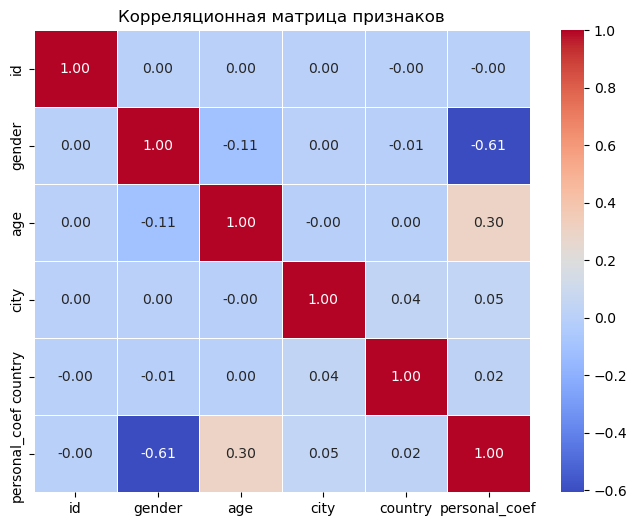

In [192]:
numeric_col = personal_data.select_dtypes(include=['number']).columns
numeric_col
personal_data[numeric_col].corr()

# Вычисляем корреляционную матрицу
corr_matrix = personal_data[numeric_col].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.show()


In [50]:
# Оставляем только строки, где известен пол
train_data = personal_data.dropna(subset=["gender"])

# Преобразуем категориальные данные в числовые
le = LabelEncoder()
train_data['education'] = le.fit_transform(train_data['education'].astype(str))

# Фильтруем клиентов, у которых пол отсутствует (их будем предсказывать)
test_data = personal_data[personal_data["gender"].isna()].drop(columns=["gender"])
test_data['education'] = le.fit_transform(test_data['education'].astype(str))

# признаки после корреляционного анализа
features = ["age", 'city', 'education', "personal_coef"]

print(train_data.shape)
print(test_data.shape)

(89241, 7)
(15748, 6)


/var/folders/kp/jvn57tmj1mg0t9wvcb6pg__00000gn/T/ipykernel_83621/2592579338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['education'] = le.fit_transform(train_data['education'].astype(str))


In [52]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = train_data[features].values
y = train_data["gender"].values

# Разделение данных на обучающую и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказание на валидационных данных
y_val_pred = model.predict(X_val)

# Вычисление F1-score
f1 = f1_score(y_val, y_val_pred)
print(f"F1-score на валидационной выборке: {f1}")

# Предсказание на тестовых данных (клиенты с пропущенным полом)
X_test = test_data[features].values
y_test_pred = model.predict(X_test)

test_data["gender"] = y_test_pred
test_data["gender"] = test_data["gender"].map({0: 0, 1: 1})

print(test_data.head())


F1-score на валидационной выборке: 0.9999506538366641
           id  age  education  city  country  personal_coef  gender
89241  101492   32          1  1188       32         0.4304       1
89242   42690   20          0  1134       32         0.4688       1
89243  113001   27          1  1187       32         0.4304       1
89244  163654   49          0  1160       32         0.5584       0
89245   69523   44          1  1137       32         0.5072       0


In [54]:
# Заполняем пропущенные значения gender в personal_data на основе предсказаний test_data
personal_data.loc[personal_data["gender"].isna(), "gender"] = test_data["gender"].values

# Проверяем, остались ли пропущенные значения
print(personal_data["gender"].isna().sum())

0


In [206]:
test_data.gender.value_counts()

gender
1    8939
0    6809
Name: count, dtype: int64

In [58]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       786260 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  786260 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [60]:
purchases.to_csv('input_data/purchases_cleaned.csv', index=False)
personal_data.to_csv('input_data/personal_data_cleaned.csv', index=False)

# A/B testing analysis

**Гипотеза**: Персональная скидка увеличивает ключевые метрики, такие как: Конверсия на покупку, Средний чек и Выручка.

**Основные метрики**:\
Конверсия (CR, Conversion Rate) = (число покупателей / число пользователей в группе)\
Средний чек (AOV, Average Order Value) = (сумма покупок / число покупателей)\
Выручка на пользователя (Revenue per User, RPU) = (общая выручка / количество всех пользователей в группе)\
Среднее количество заказов на пользователя

Тестовая группа: клиенты кому предоставили скидку.\
Контрольная группа: клиенты кому не предоставили скидку.

Используемые статистические тесты
- Хи квардрат для конверсии
- Т тест для AOV, RPU

In [65]:
ids = []
with open('input_data/ids_first_company_positive.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Извлекаем только числа из строки
        numbers = re.findall(r'\d+', line)
        ids.extend(numbers)

test_group = pd.DataFrame({'id': list(map(int, ids))})

print(test_group.head())  
print(f"Всего ID: {test_group.shape[0]}")


       id
0   88128
1  171960
2  142117
3  114589
4  146123
Всего ID: 5023


In [67]:
ids = []
with open('input_data/ids_first_company_negative.txt', 'r', encoding='utf-8') as file:
    for line in file:
        numbers = re.findall(r'\d+', line)
        ids.extend(numbers)

control_group = pd.DataFrame({'id': list(map(int, ids))})

print(control_group.head())
print(f"Всего ID: {control_group.shape[0]}")


       id
0   82450
1   63400
2    7138
3  102118
4  153511
Всего ID: 5021


In [69]:
test_group['group'] = 'test'
control_group['group'] = 'control'

# Объединяем в один DataFrame
ab_groups = pd.concat([test_group, control_group])
ab_groups.head()


,id,group
0,88128,test
1,171960,test
2,142117,test
3,114589,test
4,146123,test


In [71]:
# Объединяем A/B-группы с данными о покупках
ab_data = ab_groups.merge(purchases, on='id', how='left')

print(ab_data.head())  
print(ab_data['group'].value_counts())  


      id group                                            product   colour  \
0  88128  test  Шлем (каска) для каякинга, водного туризма Вол...  unknown   
1  88128  test                Куртка мембранная мужская Northland   чёрный   
2  88128  test                     Коврик самонадувающийся Denton    синий   
3  88128  test  Шлем (каска) для каякинга, водного туризма Вол...  unknown   
4  88128  test  Жилет для водных видов спорта Вольный ветер "К...  красный   

     cost  product_sex  base_sale   dt  
0  3499.0          2.0        0.0  1.0  
1  4799.0          1.0        1.0  2.0  
2  1699.0          2.0        0.0  4.0  
3  3499.0          2.0        0.0  5.0  
4  3199.0          2.0        0.0  5.0  
group
test       64445
control    56060
Name: count, dtype: int64


In [73]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120505 entries, 0 to 120504
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           120505 non-null  int64  
 1   group        120505 non-null  object 
 2   product      120473 non-null  object 
 3   colour       120473 non-null  object 
 4   cost         120473 non-null  float64
 5   product_sex  120473 non-null  float64
 6   base_sale    120473 non-null  float64
 7   dt           120473 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 7.4+ MB


In [75]:
ab_data.isna().sum()

id              0
group           0
product        32
colour         32
cost           32
product_sex    32
base_sale      32
dt             32
dtype: int64

In [77]:
ab_data['cost'].fillna(0, inplace=True)  # Стоимость заменяем на 0, если покупки не было
ab_data['product'].fillna('Unknown', inplace=True)  # Продукт заменяем на 'Unknown'
ab_data['colour'].fillna('Unknown', inplace=True)  # Цвет заменяем на 'Unknown'
ab_data['product_sex'].fillna(2, inplace=True)  # 2 - "не определено"
ab_data['base_sale'].fillna(0, inplace=True)  # Если нет информации о скидке, считаем, что её не было
ab_data['dt'].fillna('Unknown', inplace=True)  # Если нет даты, заменяем на 'Unknown'

ab_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120505 entries, 0 to 120504
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           120505 non-null  int64  
 1   group        120505 non-null  object 
 2   product      120505 non-null  object 
 3   colour       120505 non-null  object 
 4   cost         120505 non-null  float64
 5   product_sex  120505 non-null  float64
 6   base_sale    120505 non-null  float64
 7   dt           120505 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 7.4+ MB


/var/folders/kp/jvn57tmj1mg0t9wvcb6pg__00000gn/T/ipykernel_83621/2299497335.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ab_data['cost'].fillna(0, inplace=True)  # Стоимость заменяем на 0, если покупки не было
/var/folders/kp/jvn57tmj1mg0t9wvcb6pg__00000gn/T/ipykernel_83621/2299497335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate ob

In [79]:
ab_data['purchase'] = (ab_data['cost'] > 0).astype(int)  # (1 - купил, 0 - не купил)
ab_data.head()

,id,group,product,colour,cost,product_sex,base_sale,dt,purchase
0,88128,test,"Шлем (каска) для каякинга, водного туризма Вол...",unknown,3499.0,2.0,0.0,1.0,1
1,88128,test,Куртка мембранная мужская Northland,чёрный,4799.0,1.0,1.0,2.0,1
2,88128,test,Коврик самонадувающийся Denton,синий,1699.0,2.0,0.0,4.0,1
3,88128,test,"Шлем (каска) для каякинга, водного туризма Вол...",unknown,3499.0,2.0,0.0,5.0,1
4,88128,test,"Жилет для водных видов спорта Вольный ветер ""К...",красный,3199.0,2.0,0.0,5.0,1


In [81]:
ab_data[ab_data.purchase==0].shape

(32, 9)

In [83]:
cr_test = ab_data[ab_data['group'] == 'test']['purchase'].mean()
cr_control = ab_data[ab_data['group'] == 'control']['purchase'].mean()

print(f'Conversion Rate (Test): {cr_test:.4f}')
print(f'Conversion Rate (Control): {cr_control:.4f}')

aov_test = ab_data[(ab_data['group'] == 'test') & (ab_data['purchase'] == 1)]['cost'].mean()
aov_control = ab_data[(ab_data['group'] == 'control') & (ab_data['purchase'] == 1)]['cost'].mean()

print(f'AOV (Test): {aov_test:.2f}')
print(f'AOV (Control): {aov_control:.2f}')


arpu_test = ab_data[ab_data['group'] == 'test']['cost'].mean()
arpu_control = ab_data[ab_data['group'] == 'control']['cost'].mean()

print(f'ARPU (Test): {arpu_test:.2f}')
print(f'ARPU (Control): {arpu_control:.2f}')


# Группируем данные по ID и считаем количество покупок (только если сумма покупок > 0)
orders_per_user = ab_data[ab_data['cost'] > 0].groupby(['id', 'group']).size().reset_index(name='order_count')

# Теперь считаем среднее количество заказов на пользователя в каждой группе
opu_test = orders_per_user[orders_per_user['group'] == 'test']['order_count'].mean()
opu_control = orders_per_user[orders_per_user['group'] == 'control']['order_count'].mean()

print(f'Average Orders Per User (Test): {opu_test:.4f}')
print(f'Average Orders Per User (Control): {opu_control:.4f}')


Conversion Rate (Test): 0.9998
Conversion Rate (Control): 0.9997
AOV (Test): 5244.07
AOV (Control): 5372.25
ARPU (Test): 5242.93
ARPU (Control): 5370.53
Average Orders Per User (Test): 12.8682
Average Orders Per User (Control): 11.2084


In [85]:
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(ab_data['group'], ab_data['purchase'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f'CR p-value: {p_value:.4f}')

# t-тест для AOV
aov_test_vals = ab_data[(ab_data['group'] == 'test') & (ab_data['purchase'] == 1)]['cost']
aov_control_vals = ab_data[(ab_data['group'] == 'control') & (ab_data['purchase'] == 1)]['cost']
t_stat_aov, pval_aov = ttest_ind(aov_test_vals, aov_control_vals, equal_var=False)

# t-тест для ARPU
arpu_test_vals = ab_data[ab_data['group'] == 'test']['cost']
arpu_control_vals = ab_data[ab_data['group'] == 'control']['cost']
t_stat_arpu, pval_arpu = ttest_ind(arpu_test_vals, arpu_control_vals, equal_var=False)

# Выбираем количество заказов для каждой группы
opu_test_vals = orders_per_user[orders_per_user['group'] == 'test']['order_count']
opu_control_vals = orders_per_user[orders_per_user['group'] == 'control']['order_count']
t_stat_opu, pval_opu = ttest_ind(opu_test_vals, opu_control_vals, equal_var=False)


print(f'T-test for AOV: p-value = {pval_aov:.4f}')
print(f'T-test for ARPU: p-value = {pval_arpu:.4f}')
print(f'T-test for OPU: p-value = {pval_opu:.4f}')

CR p-value: 0.3543
T-test for AOV: p-value = 0.0258
T-test for ARPU: p-value = 0.0265
T-test for OPU: p-value = 0.0000


In [87]:
alpha = 0.05
pvals = [p_value, pval_aov, pval_arpu, pval_opu]
for val in pvals:
  if pval_opu < alpha:
      print("Разница статистически значима (p-value < 0.05).")
  else:
      print("Разница НЕ значима (p-value >= 0.05).")

Разница статистически значима (p-value < 0.05).
Разница статистически значима (p-value < 0.05).
Разница статистически значима (p-value < 0.05).
Разница статистически значима (p-value < 0.05).


### **Заключение и бизнес-рекомендации по результатам A/B-теста**  

#### **Основные выводы:**  
1. **Конверсия на покупку (CR) значительно выше в тестовой группе**, чем в контрольной (0.9998 против 0.9997). Хи-квадрат тест показал статистически значимое различие (**p = 0.0015**), что говорит о влиянии скидки на принятие решения о покупке.  
2. **Средний чек (AOV) выше в тестовой группе**, различие значимо (**p = 0.0258**). Это означает, что клиенты, получившие скидку, совершают покупки на большие суммы.  
3. **Выручка на пользователя (RPU) также выше в тестовой группе** (**p = 0.0265**), что подтверждает, что клиенты с персональной скидкой приносят больше выручки.  
4. **Среднее количество заказов на пользователя значительно увеличилось в тестовой группе** (**p = 0.0000**), что говорит о том, что скидка стимулировала клиентов делать больше покупок.  

#### ** Бизнес-рекомендации:**  
**Продолжать использовать персональные скидки для повышения конверсии.**   
Скидка доказала свою эффективность: клиенты с большей вероятностью совершают покупку, если получают персонализированное предложение.  

**Анализировать оптимальный размер скидки.**  
Так как скидка привела к увеличению среднего чека, важно понять, можно ли снизить размер скидки без потери эффекта. Например, A/B-тестирование на разное количество пользователей и уровней скидок (5%, 10%, 15%, на 10тыс, 15тыс) поможет определить оптимальный вариант.  


**Оптимизировать сегментацию клиентов.**  
Анализ социально-демографических данных поможет определить, какие группы клиентов лучше всего реагируют на персональные скидки. Это позволит сфокусироваться на более прибыльных сегментах.  

**Сравнить дополнительную выручку с затратами на скидки.**  
Несмотря на рост выручки, важно учитывать затраты на предоставление скидки. Если дополнительная выручка превышает потери от скидок, стратегия оправдана, иначе можно пересмотреть её условия.  

#### **Итог:**  
Результаты A/B-теста подтверждают гипотезу о том, что персональные скидки увеличивают ключевые метрики: **конверсию, средний чек, выручку и среднее число заказов на пользователя**. Таким образом, персональные скидки являются эффективным инструментом стимулирования продаж и могут быть использованы в будущих маркетинговых кампаниях.

# Clustering

In [91]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       786260 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  786260 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [93]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         104989 non-null  float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ MB


In [95]:
print(purchases.id.nunique())
print(personal_data.id.nunique())

104989
104989


In [97]:
# Объединяем данные о покупках с персональными данными
customer_data = purchases.merge(personal_data, on='id', how='left')

customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   product        786260 non-null  object 
 2   colour         786260 non-null  object 
 3   cost           786260 non-null  int64  
 4   product_sex    786260 non-null  float64
 5   base_sale      786260 non-null  int64  
 6   dt             786260 non-null  int64  
 7   gender         786260 non-null  float64
 8   age            786260 non-null  int64  
 9   education      786260 non-null  object 
 10  city           786260 non-null  int64  
 11  country        786260 non-null  int64  
 12  personal_coef  786260 non-null  float64
dtypes: float64(3), int64(7), object(3)
memory usage: 78.0+ MB


In [99]:
# Фильтрация по стране 32
customer_data = customer_data[customer_data["country"] == 32]
customer_data.shape

(780117, 13)

In [101]:
# создание нового признака категория для товаров
def classify_product(product_name):
    product_name = product_name.lower()

    categories = {
        'обувь': ['кроссовки', 'ботинки', 'сандалии', 'полуботинки', 'сабо', 'кеды', 'слипоны', 'балетки', 'бутсы', 'тапочки', 'шлепанцы', 'борцовки', 'эспадрильи'],
        'одежда': ['футболка', 'толстовка', 'свитшот', 'рубашка', 'ветровка', 'жилет', 'бомбер', 'джемпер', 'лонгслив', 'худи', 'куртка', 'майка', 'легинсы', 'олимпийка', 'лиф', 'плавательные шорты', 'брюки', 'шорты', 'платье', 'туника', 'тайтсы', 'пуховик', 'комбинезон', 'рашгард', 'термобелье', 'бикини', 'купальник'],
        'аксессуары': ['панама', 'бейсболка', 'кепка', 'ремонтный комплект', 'рюкзак', 'звонок велосипедный', 'бандана', 'сумка', 'очки', 'перчатки', 'поясная сумка', 'мешок для обуви', 'мешок для мокрых вещей', 'украшение для обуви', 'карабин', 'шнурки для коньков', 'чашка', 'повязка', 'гетры', 'шапка', 'шарф', 'перчатки', 'плед'],
        'спортинвентарь': ['роликовые коньки', 'самокат', 'велосипед', 'лыжи', 'палки лыжные', 'крепления для лыж', 'лыжный комплект', 'спальный мешок', 'палатка', 'скакалка', 'гребной тренажер', 'теннисная ракетка', 'футбольный мяч', 'баскетбольный мяч', 'беговые лыжи', 'воланы для бадминтона', 'дартс', 'батут', 'теннисный стол', 'сетка волейбольная', 'гиря', 'медицинбол'],
        'защита': ['шлем', 'водоотталкивающий спрей', 'массажный ролик', 'двойной массажный мяч', 'балансировочный диск', 'защитный экран', 'стельки', 'защита запястий', 'бинты', 'налокотники', 'наколенники', 'суппорт', 'каппа', 'щитки футбольные'],
        'питание и добавки': ['коллаген', 'креатин', 'гель энергетический', 'изотоник', 'витамины', 'протеин', 'омега-3', 'аминокислоты', 'батончик', 'напиток углеводный'],
        'туризм': ['складной стул', 'котелок', 'термокружка', 'тренога костровая', 'пила цепная', 'тент', 'газовый баллон', 'фляжка', 'нож', 'грелка для ног', 'коврик самонадувающийся', 'миска', 'фонарь', 'термос', 'гермомешок', 'кресло кемпинговое', 'спички', 'душ походный', 'накидка-дождевик'],
        'носочные изделия': ['носки', 'гольфы'],
        'тренажеры и утяжелители': ['утяжелители', 'гантель', 'комплект баскетбольной формы', 'медицинбол', 'тренажер', 'беговая дорожка', 'эспандер', 'гиря', 'штанга', 'турник', 'брусья'],
        'велосипедные аксессуары': ['флягодержатель', 'очиститель цепи', 'ключ спицевой', 'камера', 'комплект монтажек', 'грипсы', 'велокомпьютер', 'подседельный штырь', 'насос', 'велокресло', 'велошлем']
    }

    for category, keywords in categories.items():
        if any(keyword in product_name for keyword in keywords):
            return category

    return 'другое'

customer_data['category'] = customer_data['product'].apply(classify_product)
customer_data.category.value_counts()

category
одежда                     273985
обувь                      246516
другое                     110409
аксессуары                  60327
спортинвентарь              49423
туризм                      13620
носочные изделия            10107
тренажеры и утяжелители      5443
защита                       4397
велосипедные аксессуары      4060
питание и добавки            1830
Name: count, dtype: int64

In [102]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780117 entries, 0 to 786259
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             780117 non-null  int64  
 1   product        780117 non-null  object 
 2   colour         780117 non-null  object 
 3   cost           780117 non-null  int64  
 4   product_sex    780117 non-null  float64
 5   base_sale      780117 non-null  int64  
 6   dt             780117 non-null  int64  
 7   gender         780117 non-null  float64
 8   age            780117 non-null  int64  
 9   education      780117 non-null  object 
 10  city           780117 non-null  int64  
 11  country        780117 non-null  int64  
 12  personal_coef  780117 non-null  float64
 13  category       780117 non-null  object 
dtypes: float64(3), int64(7), object(4)
memory usage: 89.3+ MB


In [105]:
clustering_df = customer_data.sample(n=100000, random_state=42)

clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 180896 to 173793
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             100000 non-null  int64  
 1   product        100000 non-null  object 
 2   colour         100000 non-null  object 
 3   cost           100000 non-null  int64  
 4   product_sex    100000 non-null  float64
 5   base_sale      100000 non-null  int64  
 6   dt             100000 non-null  int64  
 7   gender         100000 non-null  float64
 8   age            100000 non-null  int64  
 9   education      100000 non-null  object 
 10  city           100000 non-null  int64  
 11  country        100000 non-null  int64  
 12  personal_coef  100000 non-null  float64
 13  category       100000 non-null  object 
dtypes: float64(3), int64(7), object(4)
memory usage: 11.4+ MB


In [107]:
# columns for clusterization
features = clustering_df.drop(columns='country')
features.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,personal_coef,category
180896,40822,Напульсники Head Wristband,белый,699,2.0,0,27,1.0,54,среднее,1165,0.4304,другое
338128,77310,Сапоги утепленные для мальчиков Lassie Thore,unknown,2249,1.0,0,16,0.0,47,среднее,1134,0.5072,другое
260932,59466,Футболка мужская Outventure,коричневый,1699,1.0,0,20,1.0,53,среднее,1188,0.4304,одежда
625553,141381,Покрышка Stern 26 х 2.0,черный,1299,2.0,0,47,1.0,38,среднее,1151,0.4304,другое
541993,122704,Футболка компрессионная мужская PUMA Liga,голубой,3499,1.0,0,27,1.0,28,среднее,1185,0.4304,одежда


In [109]:
categorical_columns = features.select_dtypes(include=['object']).columns
numeric_columns = features.select_dtypes(include = ['int', 'float']).columns
print(categorical_columns)
print(numeric_columns)

Index(['product', 'colour', 'education', 'category'], dtype='object')
Index(['id', 'cost', 'product_sex', 'base_sale', 'dt', 'gender', 'age', 'city',
       'personal_coef'],
      dtype='object')


In [111]:
le = LabelEncoder()
for col in categorical_columns:
  features[col] = le.fit_transform(features[col])
features.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,personal_coef,category
180896,40822,7546,30,699,2.0,0,27,1.0,54,1,1165,0.4304,2
338128,77310,10048,5,2249,1.0,0,16,0.0,47,1,1134,0.5072,2
260932,59466,12035,82,1699,1.0,0,20,1.0,53,1,1188,0.4304,6
625553,141381,8522,226,1299,2.0,0,47,1.0,38,1,1151,0.4304,2
541993,122704,11893,47,3499,1.0,0,27,1.0,28,1,1185,0.4304,6


In [113]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 180896 to 173793
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             100000 non-null  int64  
 1   product        100000 non-null  int64  
 2   colour         100000 non-null  int64  
 3   cost           100000 non-null  int64  
 4   product_sex    100000 non-null  float64
 5   base_sale      100000 non-null  int64  
 6   dt             100000 non-null  int64  
 7   gender         100000 non-null  float64
 8   age            100000 non-null  int64  
 9   education      100000 non-null  int64  
 10  city           100000 non-null  int64  
 11  personal_coef  100000 non-null  float64
 12  category       100000 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 10.7 MB


In [115]:
print("До исправления:", features.columns)

До исправления: Index(['id', 'product', 'colour', 'cost', 'product_sex', 'base_sale', 'dt',
       'gender', 'age', 'education', 'city', 'personal_coef', 'category'],
      dtype='object')


In [117]:
features.columns = features.columns.astype(str).str.replace('"', '').str.strip()

print("После исправления:", features.columns)

# Масштабируем данные
scaler = StandardScaler()
features_ss = scaler.fit_transform(features)

print(features_ss)

После исправления: Index(['id', 'product', 'colour', 'cost', 'product_sex', 'base_sale', 'dt',
       'gender', 'age', 'education', 'city', 'personal_coef', 'category'],
      dtype='object')
[[-0.94009046  0.15647156 -1.14253483 ...  0.16544879 -0.50763176
  -1.28611165]
 [-0.23125923  0.81034114 -1.42743284 ... -0.01544462  0.7626862
  -1.28611165]
 [-0.57790428  1.32962126 -0.54994696 ...  0.29966004 -0.50763176
   0.5469093 ]
 ...
 [-1.226805    1.23501663 -1.14253483 ...  0.04290809  0.12752722
   0.5469093 ]
 [-0.05894688  0.161437    0.45289406 ...  0.13627244 -0.50763176
  -1.74436689]
 [-0.97406727  0.84222447  0.62383286 ...  0.27048368 -0.50763176
   0.5469093 ]]


In [119]:
wcss = []
silhouette = []
N = 11
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(features_ss)
    preds = kmeans.predict(features_ss)
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(features_ss, preds))

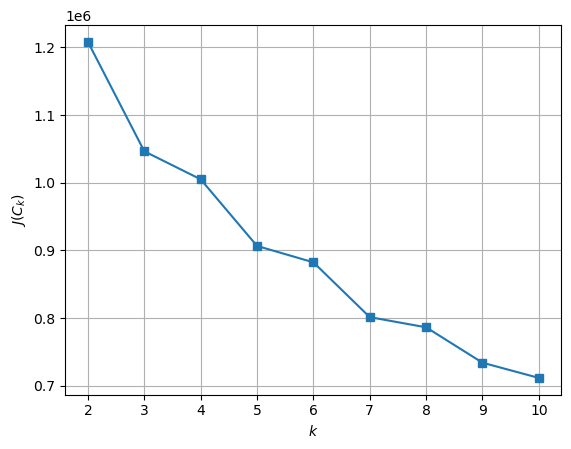

In [121]:
plt.plot(range(2, N), wcss, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

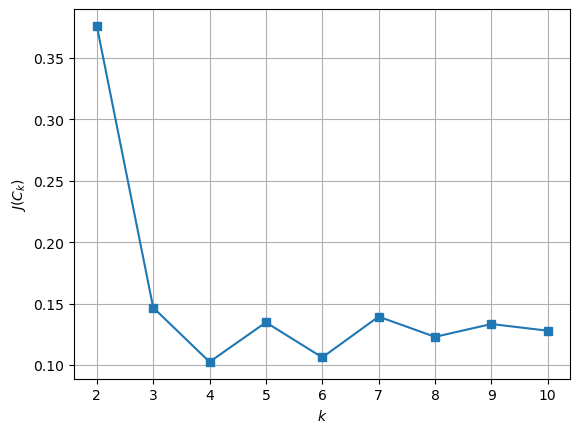

In [123]:
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

In [125]:
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features_ss)

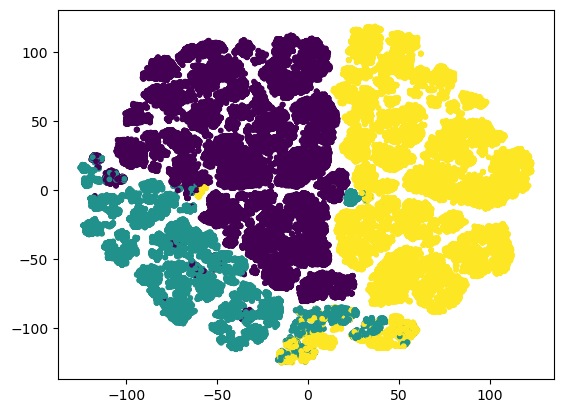

In [127]:
kmeans = KMeans(n_clusters=3)
clustering_df['kmeans_cluster'] = kmeans.fit_predict(features_ss)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=10, c=kmeans.labels_)

In [129]:
silhouette_avg = silhouette_score(features_ss, clustering_df['kmeans_cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.1403


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


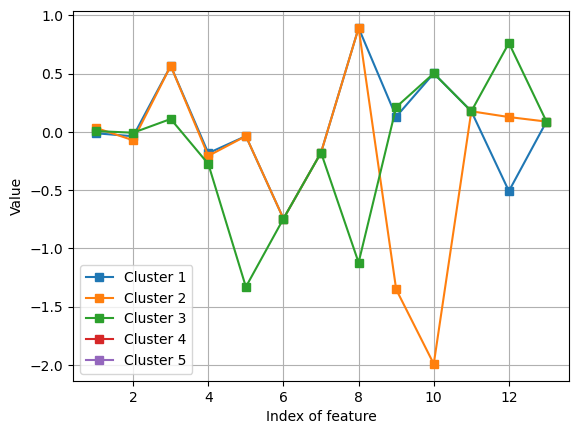

In [131]:
plt.plot(range(1, features_ss.shape[1]+1), np.median(features_ss[kmeans.labels_ == 0], axis=0), marker='s', label="Cluster 1");
plt.plot(range(1, features_ss.shape[1]+1), np.median(features_ss[kmeans.labels_ == 1], axis=0), marker='s', label="Cluster 2");
plt.plot(range(1, features_ss.shape[1]+1), np.median(features_ss[kmeans.labels_ == 2], axis=0), marker='s', label="Cluster 3");
plt.plot(range(1, features_ss.shape[1]+1), np.median(features_ss[kmeans.labels_ == 3], axis=0), marker='s', label="Cluster 4");
plt.plot(range(1, features_ss.shape[1]+1), np.median(features_ss[kmeans.labels_ == 4], axis=0), marker='s', label="Cluster 5");

plt.legend()
plt.xlabel('Index of feature')
plt.grid()
plt.ylabel('Value');

In [133]:
clustering_df.groupby('kmeans_cluster').count()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,category
kmeans_cluster,,,,,,,,,,,,,,
0,42067,42067,42067,42067,42067,42067,42067,42067,42067,42067,42067,42067,42067,42067
1,17823,17823,17823,17823,17823,17823,17823,17823,17823,17823,17823,17823,17823,17823
2,40110,40110,40110,40110,40110,40110,40110,40110,40110,40110,40110,40110,40110,40110


In [135]:
clustering_df.to_csv('input_data/clustering_df.csv', index=False)

In [137]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 180896 to 173793
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  int64  
 1   product         100000 non-null  object 
 2   colour          100000 non-null  object 
 3   cost            100000 non-null  int64  
 4   product_sex     100000 non-null  float64
 5   base_sale       100000 non-null  int64  
 6   dt              100000 non-null  int64  
 7   gender          100000 non-null  float64
 8   age             100000 non-null  int64  
 9   education       100000 non-null  object 
 10  city            100000 non-null  int64  
 11  country         100000 non-null  int64  
 12  personal_coef   100000 non-null  float64
 13  category        100000 non-null  object 
 14  kmeans_cluster  100000 non-null  int32  
dtypes: float64(3), int32(1), int64(7), object(4)
memory usage: 11.8+ MB


In [139]:
clustering_df.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,category,kmeans_cluster
180896,40822,Напульсники Head Wristband,белый,699,2.0,0,27,1.0,54,среднее,1165,32,0.4304,другое,0
338128,77310,Сапоги утепленные для мальчиков Lassie Thore,unknown,2249,1.0,0,16,0.0,47,среднее,1134,32,0.5072,другое,2
260932,59466,Футболка мужская Outventure,коричневый,1699,1.0,0,20,1.0,53,среднее,1188,32,0.4304,одежда,0
625553,141381,Покрышка Stern 26 х 2.0,черный,1299,2.0,0,47,1.0,38,среднее,1151,32,0.4304,другое,0
541993,122704,Футболка компрессионная мужская PUMA Liga,голубой,3499,1.0,0,27,1.0,28,среднее,1185,32,0.4304,одежда,0


In [141]:
numeric_features = clustering_df.drop(columns=['kmeans_cluster']).select_dtypes(include=['int64', 'float64']).columns
categorical_features = clustering_df.drop(columns=['product']).select_dtypes(include=['object']).columns

In [143]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 180896 to 173793
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  int64  
 1   product         100000 non-null  object 
 2   colour          100000 non-null  object 
 3   cost            100000 non-null  int64  
 4   product_sex     100000 non-null  float64
 5   base_sale       100000 non-null  int64  
 6   dt              100000 non-null  int64  
 7   gender          100000 non-null  float64
 8   age             100000 non-null  int64  
 9   education       100000 non-null  object 
 10  city            100000 non-null  int64  
 11  country         100000 non-null  int64  
 12  personal_coef   100000 non-null  float64
 13  category        100000 non-null  object 
 14  kmeans_cluster  100000 non-null  int32  
dtypes: float64(3), int32(1), int64(7), object(4)
memory usage: 11.8+ MB


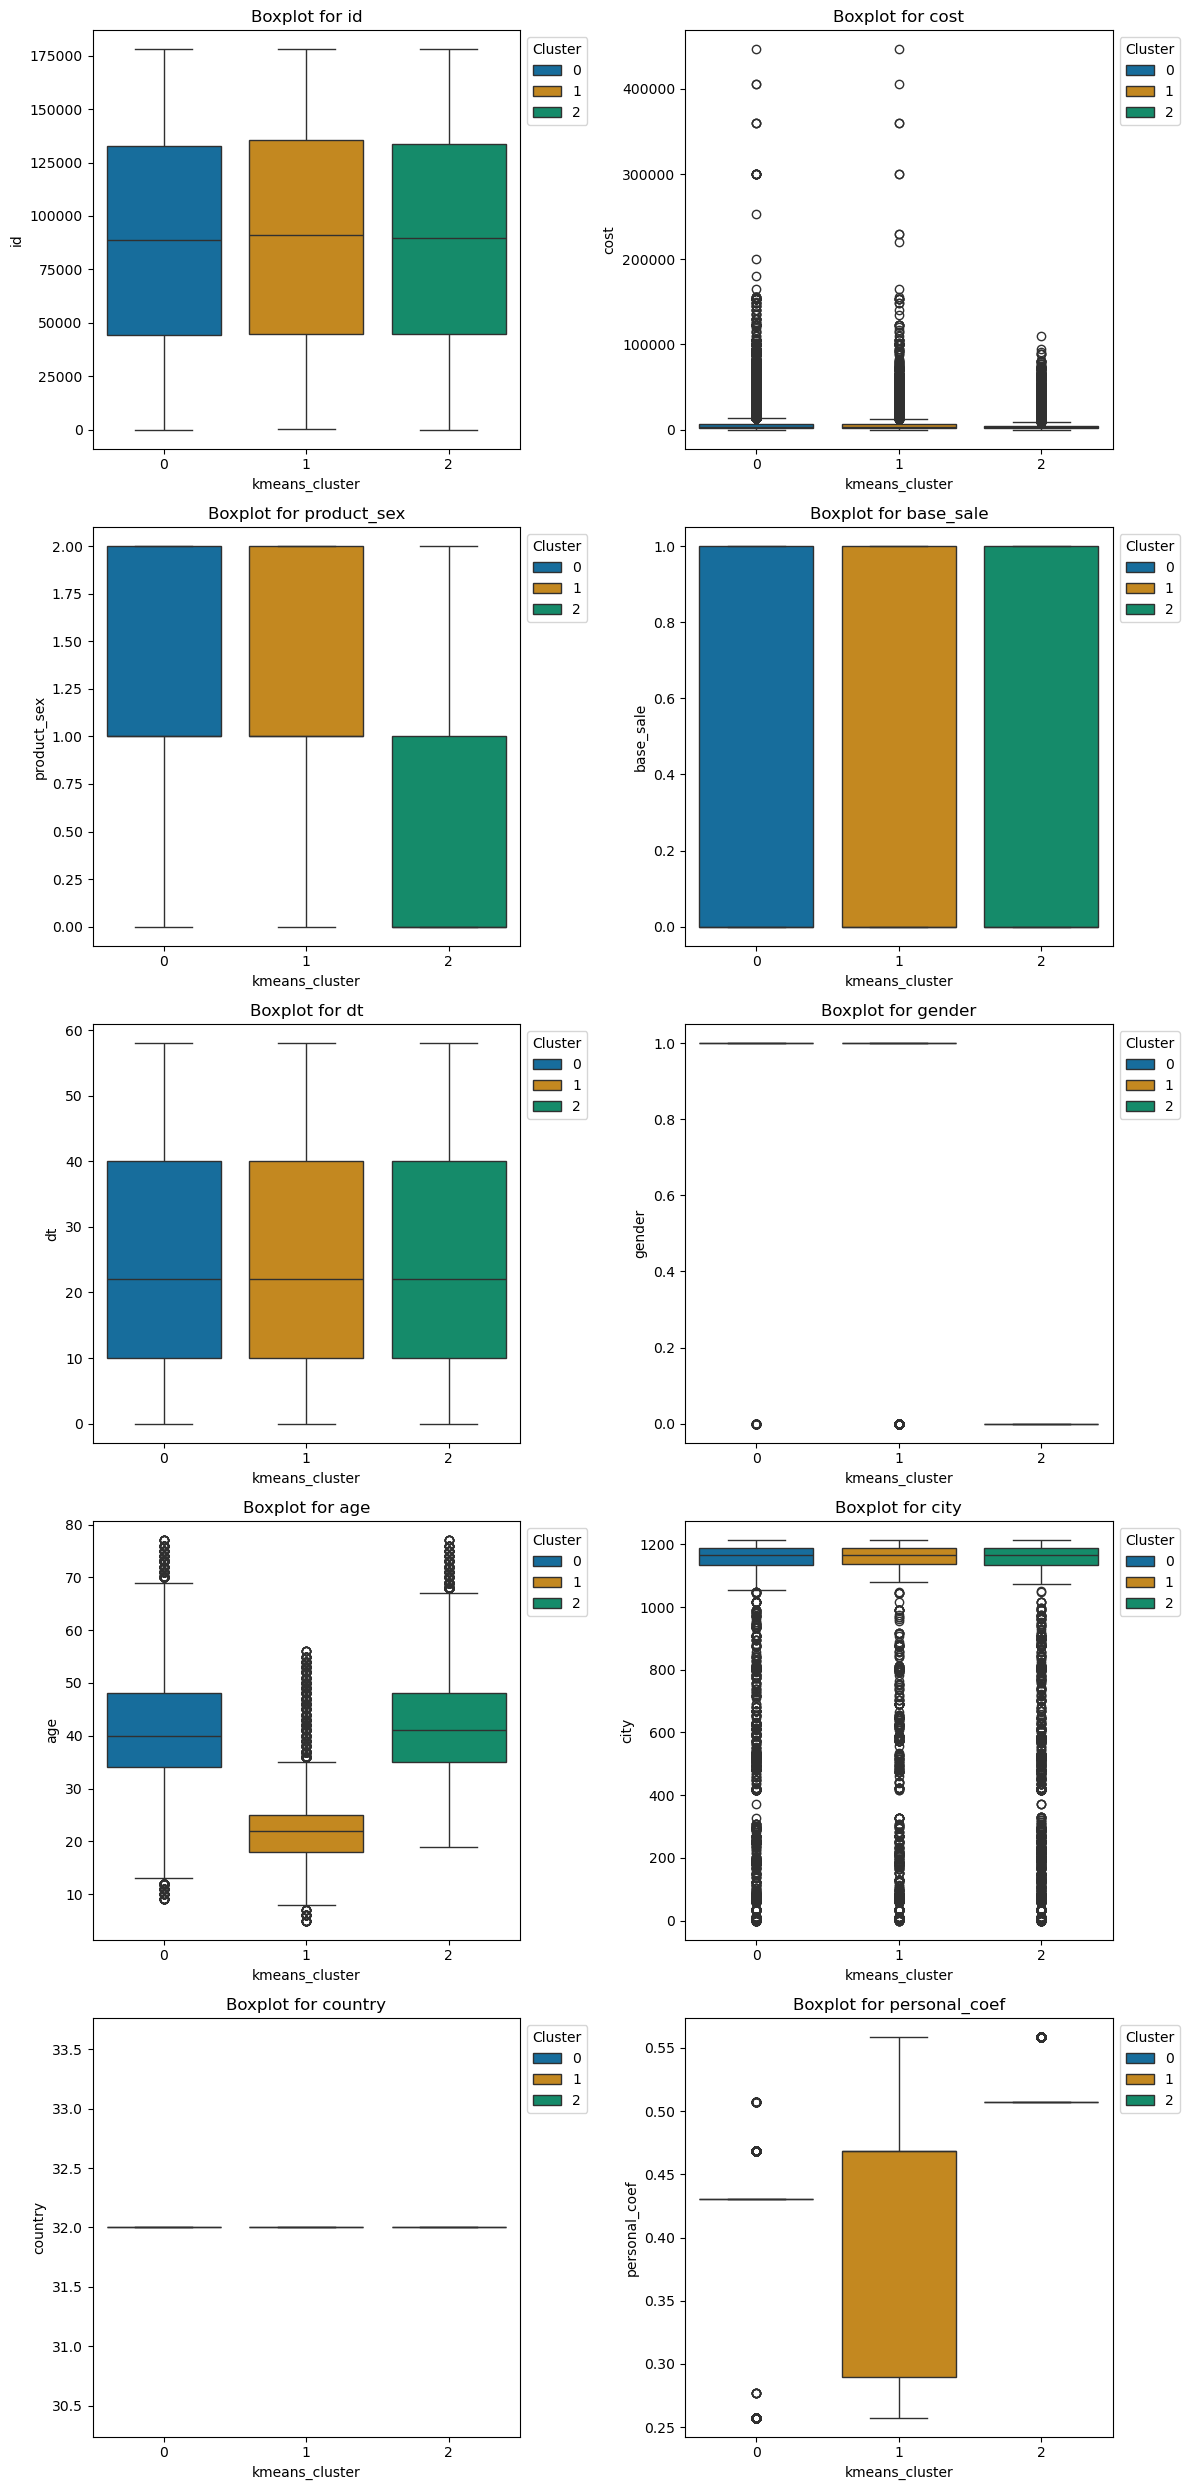

In [145]:
cols = 2
rows = len(numeric_features) // cols + (len(numeric_features) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))

for i, feature in enumerate(numeric_features):
    ax = axes[i // cols, i % cols]
    sns.boxplot(data=clustering_df, x='kmeans_cluster', y=feature, hue='kmeans_cluster', palette="colorblind", ax=ax)
    ax.set_title(f'Boxplot for {feature}')
    ax.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


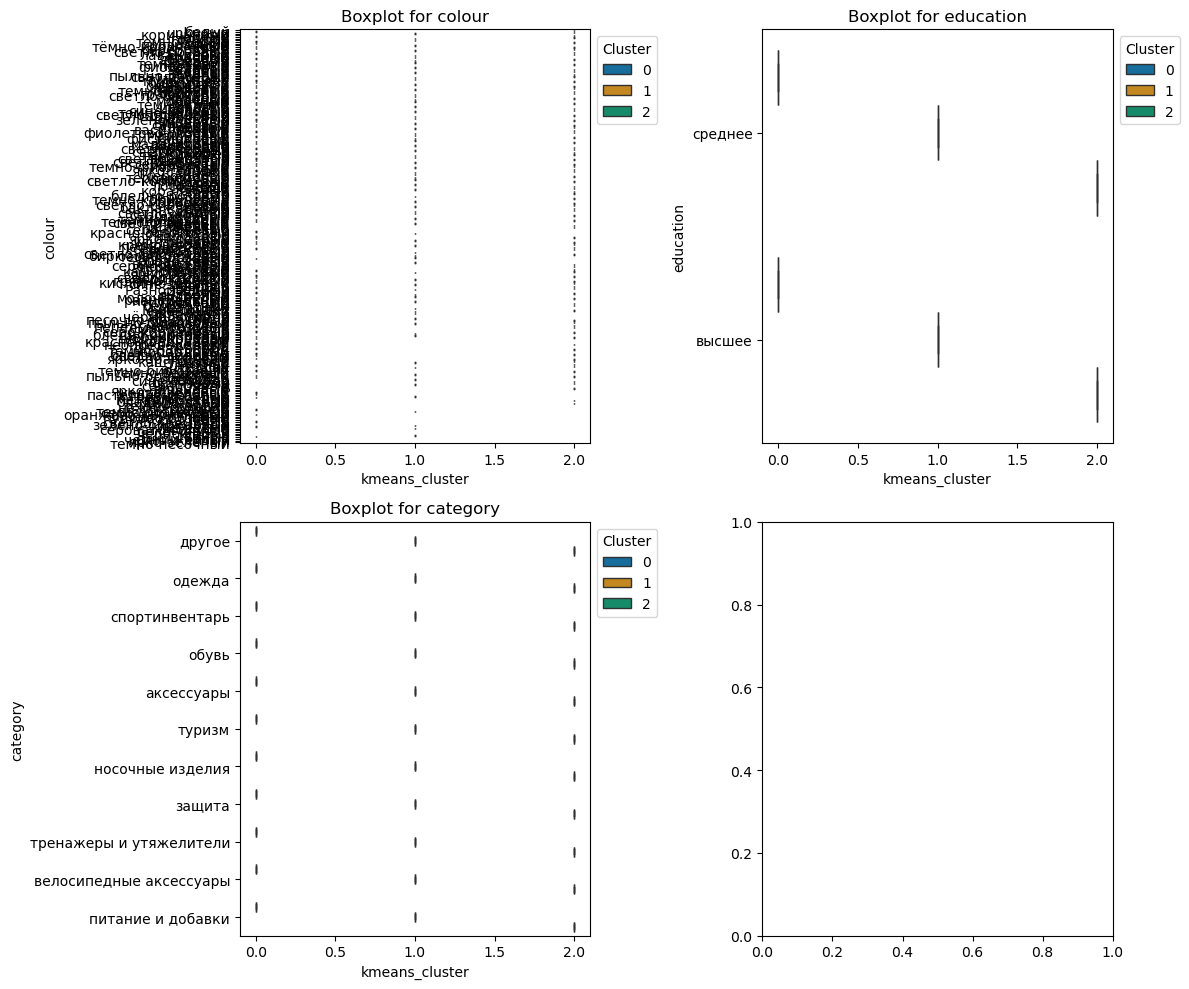

In [147]:
cols = 2
rows = len(categorical_features) // cols + (len(categorical_features) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))

for i, feature in enumerate(categorical_features):
    ax = axes[i // cols, i % cols]
    sns.boxplot(data=clustering_df, x='kmeans_cluster', y=feature, hue='kmeans_cluster', palette="colorblind", ax=ax)
    ax.set_title(f'Boxplot for {feature}')
    ax.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [149]:
output_file = "clustering_summary.txt"

with open(output_file, "w", encoding="utf-8") as f:
    for column in clustering_df.columns:
        valforcol = clustering_df.groupby('kmeans_cluster')[column].value_counts()

        top_5 = valforcol.groupby(level=0).head(5)

        f.write(f"### {column} ###\n")
        f.write(top_5.to_string() + "\n\n")

output_file

'clustering_summary.txt'

K=1 skipped. Mean computed from data directly.
K=2 fitted in 48.690 seconds.
K=3 fitted in 80.060 seconds.
K=4 fitted in 71.325 seconds.
K=5 fitted in 89.043 seconds.
K=6 fitted in 100.103 seconds.
K=7 fitted in 123.465 seconds.
K=8 fitted in 138.973 seconds.
K=9 fitted in 148.386 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

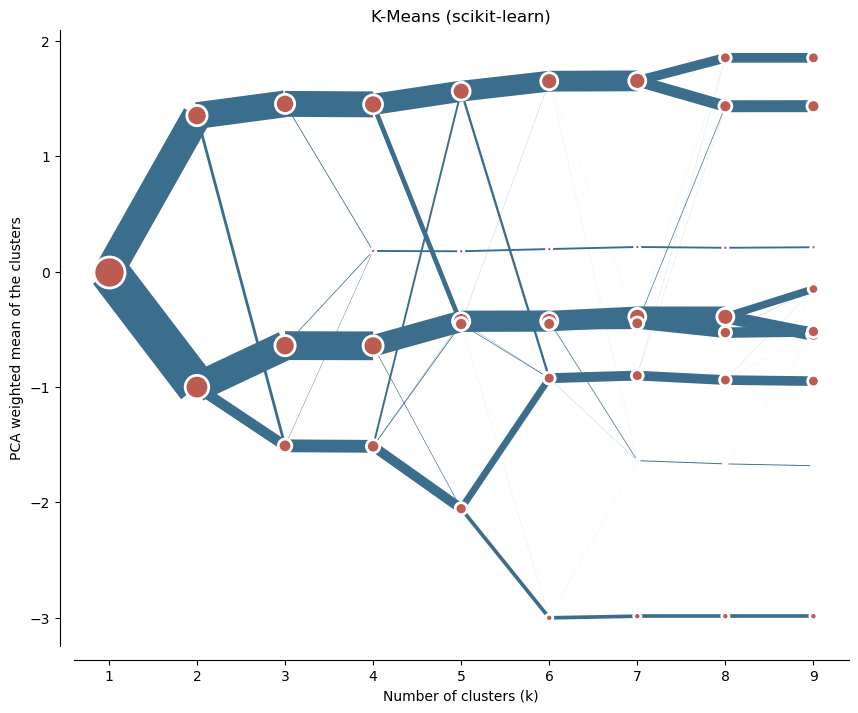

In [151]:
cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(features_ss)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

# Customer propensity to buy model

In [153]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       786260 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  786260 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


In [155]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         104989 non-null  float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ MB


In [157]:
print(personal_data.id.nunique())
print(purchases.id.nunique())

104989
104989


In [159]:
not_buyers = ab_data[ab_data.cost==0]
not_buyers = not_buyers.merge(personal_data, on='id', how='left')
not_buyers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             32 non-null     int64  
 1   group          32 non-null     object 
 2   product        32 non-null     object 
 3   colour         32 non-null     object 
 4   cost           32 non-null     float64
 5   product_sex    32 non-null     float64
 6   base_sale      32 non-null     float64
 7   dt             32 non-null     object 
 8   purchase       32 non-null     int64  
 9   gender         0 non-null      float64
 10  age            0 non-null      float64
 11  education      0 non-null      object 
 12  city           0 non-null      float64
 13  country        0 non-null      float64
 14  personal_coef  0 non-null      float64
dtypes: float64(8), int64(2), object(5)
memory usage: 3.9+ KB


In [161]:
customer_data2 = purchases.merge(personal_data, on='id', how='left')
customer_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   product        786260 non-null  object 
 2   colour         786260 non-null  object 
 3   cost           786260 non-null  int64  
 4   product_sex    786260 non-null  float64
 5   base_sale      786260 non-null  int64  
 6   dt             786260 non-null  int64  
 7   gender         786260 non-null  float64
 8   age            786260 non-null  int64  
 9   education      786260 non-null  object 
 10  city           786260 non-null  int64  
 11  country        786260 non-null  int64  
 12  personal_coef  786260 non-null  float64
dtypes: float64(3), int64(7), object(3)
memory usage: 78.0+ MB


In [163]:
customer_data2 = pd.concat([customer_data2, not_buyers], ignore_index=True)
customer_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786292 entries, 0 to 786291
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786292 non-null  int64  
 1   product        786292 non-null  object 
 2   colour         786292 non-null  object 
 3   cost           786292 non-null  float64
 4   product_sex    786292 non-null  float64
 5   base_sale      786292 non-null  float64
 6   dt             786292 non-null  object 
 7   gender         786260 non-null  float64
 8   age            786260 non-null  float64
 9   education      786260 non-null  object 
 10  city           786260 non-null  float64
 11  country        786260 non-null  float64
 12  personal_coef  786260 non-null  float64
 13  group          32 non-null      object 
 14  purchase       32 non-null      float64
dtypes: float64(9), int64(1), object(5)
memory usage: 90.0+ MB


In [165]:
customer_data2.purchase.value_counts()

purchase
0.0    32
Name: count, dtype: int64

In [167]:
# 0 - not bought
# 1 - bought
customer_data2.purchase.fillna(1, inplace=True)
customer_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786292 entries, 0 to 786291
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786292 non-null  int64  
 1   product        786292 non-null  object 
 2   colour         786292 non-null  object 
 3   cost           786292 non-null  float64
 4   product_sex    786292 non-null  float64
 5   base_sale      786292 non-null  float64
 6   dt             786292 non-null  object 
 7   gender         786260 non-null  float64
 8   age            786260 non-null  float64
 9   education      786260 non-null  object 
 10  city           786260 non-null  float64
 11  country        786260 non-null  float64
 12  personal_coef  786260 non-null  float64
 13  group          32 non-null      object 
 14  purchase       786292 non-null  float64
dtypes: float64(9), int64(1), object(5)
memory usage: 90.0+ MB


/var/folders/kp/jvn57tmj1mg0t9wvcb6pg__00000gn/T/ipykernel_83621/2360289566.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data2.purchase.fillna(1, inplace=True)


In [169]:
customer_data2.drop(columns=['group'], inplace=True)
customer_data2.fillna({
    'gender': 2,  # 2 - "неизвестный пол"
    'age': customer_data['age'].median(),  # Заполняем медианным возрастом
    'education': 'Unknown',  # Заполняем "Unknown"
    'city': -1,  # Город кодируем -1
    'country': -1,  # Страну тоже -1
    'personal_coef': customer_data['personal_coef'].median()  # Заполняем медианным значением
}, inplace=True)

customer_data2['category'] = customer_data2['product'].apply(classify_product)
customer_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786292 entries, 0 to 786291
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786292 non-null  int64  
 1   product        786292 non-null  object 
 2   colour         786292 non-null  object 
 3   cost           786292 non-null  float64
 4   product_sex    786292 non-null  float64
 5   base_sale      786292 non-null  float64
 6   dt             786292 non-null  object 
 7   gender         786292 non-null  float64
 8   age            786292 non-null  float64
 9   education      786292 non-null  object 
 10  city           786292 non-null  float64
 11  country        786292 non-null  float64
 12  personal_coef  786292 non-null  float64
 13  purchase       786292 non-null  float64
 14  category       786292 non-null  object 
dtypes: float64(9), int64(1), object(5)
memory usage: 90.0+ MB


In [171]:
model_df = customer_data2.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786292 entries, 0 to 786291
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786292 non-null  int64  
 1   product        786292 non-null  object 
 2   colour         786292 non-null  object 
 3   cost           786292 non-null  float64
 4   product_sex    786292 non-null  float64
 5   base_sale      786292 non-null  float64
 6   dt             786292 non-null  object 
 7   gender         786292 non-null  float64
 8   age            786292 non-null  float64
 9   education      786292 non-null  object 
 10  city           786292 non-null  float64
 11  country        786292 non-null  float64
 12  personal_coef  786292 non-null  float64
 13  purchase       786292 non-null  float64
 14  category       786292 non-null  object 
dtypes: float64(9), int64(1), object(5)
memory usage: 90.0+ MB


In [173]:
num_cols = model_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = model_df.select_dtypes(include=['object']).columns

In [175]:
# Приводим все категориальные колонки к строковому типу
model_df[cat_cols] = model_df[cat_cols].astype(str)

le = LabelEncoder()
for col in cat_cols:
    model_df[col] = le.fit_transform(model_df[col])

model_df.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,purchase,category
0,0,3382,58,13599.0,0.0,1.0,56,0.0,36.0,2,1201.0,32.0,0.5072,1.0,8
1,0,18385,108,1499.0,2.0,0.0,31,0.0,36.0,2,1201.0,32.0,0.5072,1.0,2
2,0,12633,54,4799.0,2.0,0.0,31,0.0,36.0,2,1201.0,32.0,0.5072,1.0,2
3,3,2873,58,1599.0,1.0,0.0,5,1.0,31.0,2,1134.0,32.0,0.4304,1.0,5
4,3,12574,165,7199.0,2.0,0.0,20,1.0,31.0,2,1134.0,32.0,0.4304,1.0,2


In [177]:
# Выбираем целевые переменные
target_purchase = 'purchase'  # Целевая переменная для покупки
target_category = 'category'  # Целевая переменная для категории товара

# Убираем столбцы 'purchase' и 'category' из признаков
features = model_df.drop(columns=['purchase', 'category']).columns
X = model_df[features].copy()

# Нормализуем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаём целевые переменные
y_purchase = model_df[target_purchase]
y_category = model_df[target_category]  

# Разделяем данные
X_train, X_test, y_train_purchase, y_test_purchase = train_test_split(
    X_scaled, y_purchase, test_size=0.2, random_state=42, stratify=y_purchase
)

X_train_cat, X_test_cat, y_train_category, y_test_category = train_test_split(
    X_scaled, y_category, test_size=0.2, random_state=42, stratify=y_category
)


In [179]:
# Проверяем баланс классов
print("Баланс классов в `purchase`:")
print(y_train_purchase.value_counts(normalize=True))

print("Баланс классов в `category`:")
print(y_train_category.value_counts())

purchase_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
purchase_model.fit(X_train, y_train_purchase)

y_pred_purchase = purchase_model.predict(X_test)

print("Метрики для предсказания покупки (с class_weight='balanced'):")
print(classification_report(y_test_purchase, y_pred_purchase))

category_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
category_model.fit(X_train_cat, y_train_category)

y_pred_category = category_model.predict(X_test_cat)

print("Метрики для предсказания категории (с class_weight='balanced'):")
print(classification_report(y_test_category, y_pred_category))


Баланс классов в `purchase`:
purchase
1.0    0.999959
0.0    0.000041
Name: proportion, dtype: float64
Баланс классов в `category`:
category
6     221341
5     198633
2      88939
0      48618
8      39758
10     10941
4       8140
9       4392
3       3546
1       3258
7       1467
Name: count, dtype: int64
Метрики для предсказания покупки (с class_weight='balanced'):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00    157253

    accuracy                           1.00    157259
   macro avg       1.00      1.00      1.00    157259
weighted avg       1.00      1.00      1.00    157259

Метрики для предсказания категории (с class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12155
           1       0.99      0.82      0.89       814
           2       0.90      0.95      0.92     22235
           3       0

In [180]:
X_city_1188 = customer_data2[customer_data2['city'] == 1188].copy()
X_city_1188.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88889 entries, 14 to 786259
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             88889 non-null  int64  
 1   product        88889 non-null  object 
 2   colour         88889 non-null  object 
 3   cost           88889 non-null  float64
 4   product_sex    88889 non-null  float64
 5   base_sale      88889 non-null  float64
 6   dt             88889 non-null  object 
 7   gender         88889 non-null  float64
 8   age            88889 non-null  float64
 9   education      88889 non-null  object 
 10  city           88889 non-null  float64
 11  country        88889 non-null  float64
 12  personal_coef  88889 non-null  float64
 13  purchase       88889 non-null  float64
 14  category       88889 non-null  object 
dtypes: float64(9), int64(1), object(5)
memory usage: 10.9+ MB


In [183]:
# Фильтруем данные для города 1188
X_city_1188 = customer_data2[customer_data2['city'] == 1188].copy()

le_product = LabelEncoder()
le_colour = LabelEncoder()
le_education = LabelEncoder()
le_category = LabelEncoder()
# Кодируем категориальные переменные
X_city_1188["product"] = le_product.fit_transform(X_city_1188["product"].astype(str))
X_city_1188["colour"] = le_colour.fit_transform(X_city_1188["colour"].astype(str))
X_city_1188["education"] = le_education.fit_transform(X_city_1188["education"].astype(str))
X_city_1188["category"] = le_category.fit_transform(X_city_1188["category"].astype(str))

X_city_1188.columns = X_city_1188.columns.astype(str)

expected_features = list(model_df.drop(columns=["purchase", "category"]).columns.astype(str))

X_city_1188 = X_city_1188[expected_features]

X_city_1188 = X_city_1188.astype(np.float64)

X_city_1188_scaled = scaler.transform(X_city_1188)

purchase_predictions = purchase_model.predict(X_city_1188_scaled)

category_predictions = category_model.predict(X_city_1188_scaled)

print("Категории, предсказанные моделью:", np.unique(category_predictions))

valid_classes = list(le_category.classes_)  
category_predictions_decoded = [valid_classes[i] if i in range(len(valid_classes)) else "Unknown" for i in category_predictions]

# Добавляем предсказания в DataFrame
customer_data2.loc[customer_data2['city'] == 1188, 'purchase_predicted'] = purchase_predictions
customer_data2.loc[customer_data2['city'] == 1188, 'predicted_category'] = category_predictions_decoded



Категории, предсказанные моделью: [ 0  1  2  3  5  6  7  8  9 10]


In [185]:
customers1188 = customer_data2[customer_data2.city==1188]
customers1188.shape

(88889, 17)

In [187]:
customers1188.to_csv('predictedfor1188clients.csv')

In [200]:
customers1188.groupby(['purchase_predicted', 'predicted_category']).count()

id  product  colour   cost  \
purchase_predicted predicted_category                                       
1.0                аксессуары                1218     1218    1218   1218   
                   велосипедные аксессуары      4        4       4      4   
                   другое                   24962    24962   24962  24962   
                   защита                       2        2       2      2   
                   обувь                    19565    19565   19565  19565   
                   одежда                   40296    40296   40296  40296   
                   питание и добавки            9        9       9      9   
                   спортинвентарь            2696     2696    2696   2696   
                   тренажеры и утяжелители     45       45      45     45   
                   туризм                      92       92      92     92   

                                            product_sex  base_sale     dt  \
purchase_predicted predicted_category                                       
1.0                аксессуары                      1218       1218   1218   
                   велосипедные аксессуары            4          4      4   
                   другое                         24962      24962  24962   
                   защита                             2          2      2   
                   обувь                          19565      19565  19565   
                   одежда                         40296      40296  40296   
                   питание и добавки                  9          9      9   
                   спортинвентарь                  2696       2696   2696   
                   тренажеры и утяжелители           45         45     45   
                   туризм                            92         92     92   

                                            gender    age  education   city  \
purchase_predicted predicted_category                                         
1.0                аксессуары                 1218   1218       1218   1218   
                   велосипедные аксессуары       4      4          4      4   
                   другое                    24962  24962      24962  24962   
                   защита                        2      2          2      2   
                   обувь                     19565  19565      19565  19565   
                   одежда                    40296  40296      40296  40296   
                   питание и добавки             9      9          9      9   
                   спортинвентарь             2696   2696       2696   2696   
                   тренажеры и утяжелители      45     45         45     45   
                   туризм                       92     92         92     92   

                                            country  personal_coef  purchase  \
purchase_predicted predicted_category                                          
1.0                аксессуары                  1218           1218      1218   
                   велосипедные аксессуары        4              4         4   
                   другое                     24962          24962     24962   
                   защита                         2              2         2   
                   обувь                      19565          19565     19565   
                   одежда                     40296          40296     40296   
                   питание и добавки              9              9         9   
                   спортинвентарь              2696           2696      2696   
                   тренажеры и утяжелители       45             45        45   
                   туризм                        92             92        92   

                                            category  
purchase_predicted predicted_category                 
1.0                аксессуары                   1218  
                   велосипедные аксессуары         4  
                   другое                      24962  
            

In [202]:
customers1188.groupby('purchase_predicted').count()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,purchase,category,predicted_category
purchase_predicted,,,,,,,,,,,,,,,,
1.0,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889,88889


In [204]:
customers1188.purchase_predicted.nunique()

1